## 1. Data Prep & Feature Engineering
LightGBM sees one row at a time with no sense of sequence. To give it temporal context, we engineer rolling means, lag features, and rates of change, manually building the "memory" that the LSTM learns on its own.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('../data/raw/battery_failure_surfaces.csv')
df = df.drop(columns=['cumulative_high_temp_cycles'])
df['cell_id'] = (df.groupby('cell_chemistry')['cycle'].diff()<0).cumsum()


# Stratified temporal split by cell
train_keys = set()
val_keys = set()
test_keys = set()


for chem in df['cell_chemistry'].unique():
    chem_cells = sorted(df[df['cell_chemistry'] == chem]['cell_id'].unique())
    n = len(chem_cells)
    train_keys.update(chem_cells[:int(n * 0.7)])
    val_keys.update(chem_cells[int(n * 0.7):int(n * 0.85)])
    test_keys.update(chem_cells[int(n * 0.85):])

df['split'] = df['cell_id'].map(
    lambda cid: "train" if cid in train_keys
    else 'val' if cid in val_keys
    else 'test'
)

# Feature Engineering
df = df.sort_values(['cell_id','cycle'])

for window in [5,10]:
    df[f'capacity_rolling_mean_{window}'] = (
        df.groupby('cell_id')['capacity_retention_%']
        .transform(lambda x: x.rolling(window,min_periods=1).mean())
    )

    df[f'temp_rolling_mean_{window}'] = (
        df.groupby('cell_id')['cell_temperature_C']
        .transform(lambda x: x.rolling(window,min_periods=1).mean())
    )

df['capacity_lag_1'] = df.groupby('cell_id')['capacity_retention_%'].shift(1)
df['capacity_lag_5'] = df.groupby('cell_id')['capacity_retention_%'].shift(5)
df['capacity_delta'] = df.groupby('cell_id')['capacity_retention_%'].diff()
df['damage_delta'] = df.groupby('cell_id')['irreversible_damage_index'].diff()

df['target'] = df.groupby('cell_id')['capacity_retention_%'].shift(-1)

# Drop NaN rows
df = df.dropna()

# One-hot encode cell chemistry
df = pd.get_dummies(df, columns=['cell_chemistry'], dtype=float)


FEATURE_COLS =[
    'cycle', 'charge_rate_C', 'discharge_rate_C', 'cell_temperature_C',
    'internal_resistance_mOhm', 'capacity_retention_%',
    'fast_charge_exposure_cycles', 'irreversible_damage_index',
    'thermal_runaway_risk_score',
    'capacity_rolling_mean_5', 'capacity_rolling_mean_10',
    'temp_rolling_mean_5', 'temp_rolling_mean_10',
    'capacity_lag_1', 'capacity_lag_5',
    'capacity_delta', 'damage_delta',
    'cell_chemistry_LFP', 'cell_chemistry_Li-ion NMC', 'cell_chemistry_Solid-State',
]


X_train = df[df['split'] == 'train'][FEATURE_COLS]
y_train = df[df['split'] == 'train']['target']
X_val = df[df['split'] == 'val'][FEATURE_COLS]
y_val = df[df['split'] == 'val']['target']
X_test = df[df['split'] == 'test'][FEATURE_COLS]
y_test = df[df['split'] == 'test']['target']

print(f'Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}')

Train: 329308, Val: 69756, Test: 71001


## 2. Quantile Regression — LightGBM
Three models trained at the 5th, 50th, and 95th percentiles. Instead of predicting just the expected capacity, this gives us a range: worst case, most likely, and best case. The 5th percentile model is the most important.It answers "how bad could it get?"

In [2]:
quantiles = [0.05,0.50,0.95]
models = {}

for q in quantiles:
    print(f'Training quantile {q}...')
    models[q]  = lgb.LGBMRegressor(
        objective='quantile',
        alpha=q,
        learning_rate=0.05,
        n_estimators=2000,
        num_leaves=31,
        verbose=-1,
    )
    
    models[q].fit(
        X_train, y_train,
        eval_set=[(X_val,y_val)],
        callbacks=[lgb.early_stopping(50),lgb.log_evaluation(200)],
    )

print("Done")

Training quantile 0.05...
Training until validation scores don't improve for 50 rounds
[200]	valid_0's quantile: 0.113086
[400]	valid_0's quantile: 0.0389557
[600]	valid_0's quantile: 0.0179077
[800]	valid_0's quantile: 0.00999191
[1000]	valid_0's quantile: 0.00767501
[1200]	valid_0's quantile: 0.00701976
[1400]	valid_0's quantile: 0.00679487
[1600]	valid_0's quantile: 0.00650182
[1800]	valid_0's quantile: 0.00606463
[2000]	valid_0's quantile: 0.00588797
Did not meet early stopping. Best iteration is:
[2000]	valid_0's quantile: 0.00588797
Training quantile 0.5...
Training until validation scores don't improve for 50 rounds
[200]	valid_0's quantile: 0.0382166
[400]	valid_0's quantile: 0.0318255
[600]	valid_0's quantile: 0.0291539
[800]	valid_0's quantile: 0.027365
[1000]	valid_0's quantile: 0.0260011
[1200]	valid_0's quantile: 0.0251459
[1400]	valid_0's quantile: 0.0243899
[1600]	valid_0's quantile: 0.0236376
[1800]	valid_0's quantile: 0.0232745
[2000]	valid_0's quantile: 0.022896
Did n

## 3. Test Set Evaluation
Evaluate the median model (50th percentile). MAE on the worst 25% of predictions is the key metric. These are the fast-degrading cells where prediction accuracy matters most.

In [3]:
# Median model (q=0.50) for direct comparison with LSTM
preds_median = models[0.50].predict(X_test)
preds_low = models[0.05].predict(X_test)
preds_high = models[0.95].predict(X_test)

errors = np.abs(preds_median - y_test)
mae = errors.mean()
rmse = np.sqrt((errors*2).mean())
tail_mae = errors[errors >= np.percentile(errors,75)].mean()

print(f'LightGBM Median — MAE: {mae:.4f}% | RMSE: {rmse:.4f}% | Worst 25% MAE: {tail_mae:.4f}%')


LightGBM Median — MAE: 0.0411% | RMSE: 0.2868% | Worst 25% MAE: 0.1453%


## 4. Per-Chemistry Performance
Check if the model struggles with any particular chemistry. NMC is the most volatile and hardest to predict, Solid-State is the most stable.

In [ ]:
for chem in ['LFP', 'Li-ion NMC', 'Solid-State']:
    col = f'cell_chemistry_{chem}'
    mask = X_test[col] == 1
    chem_errors = errors[mask]
    chem_mae = chem_errors.mean()
    chem_tail = chem_errors[chem_errors >= np.percentile(chem_errors, 75)].mean()
    print(f'{chem:15s} | MAE: {chem_mae:.4f}% | Worst 25% MAE: {chem_tail:.4f}%')

LFP             | MAE: 0.0529% | Worst 25% MAE: 0.1912%
Li-ion NMC      | MAE: 0.0554% | Worst 25% MAE: 0.2019%
Solid-State     | MAE: 0.0214% | Worst 25% MAE: 0.0674%


## 5. Prediction Intervals — Fan Chart
For sample test cells, plot the 5th–95th percentile band with the median prediction and actual capacity. Narrow bands = model is confident. Wide bands = high uncertainty, typically near the capacity cliff before failure.

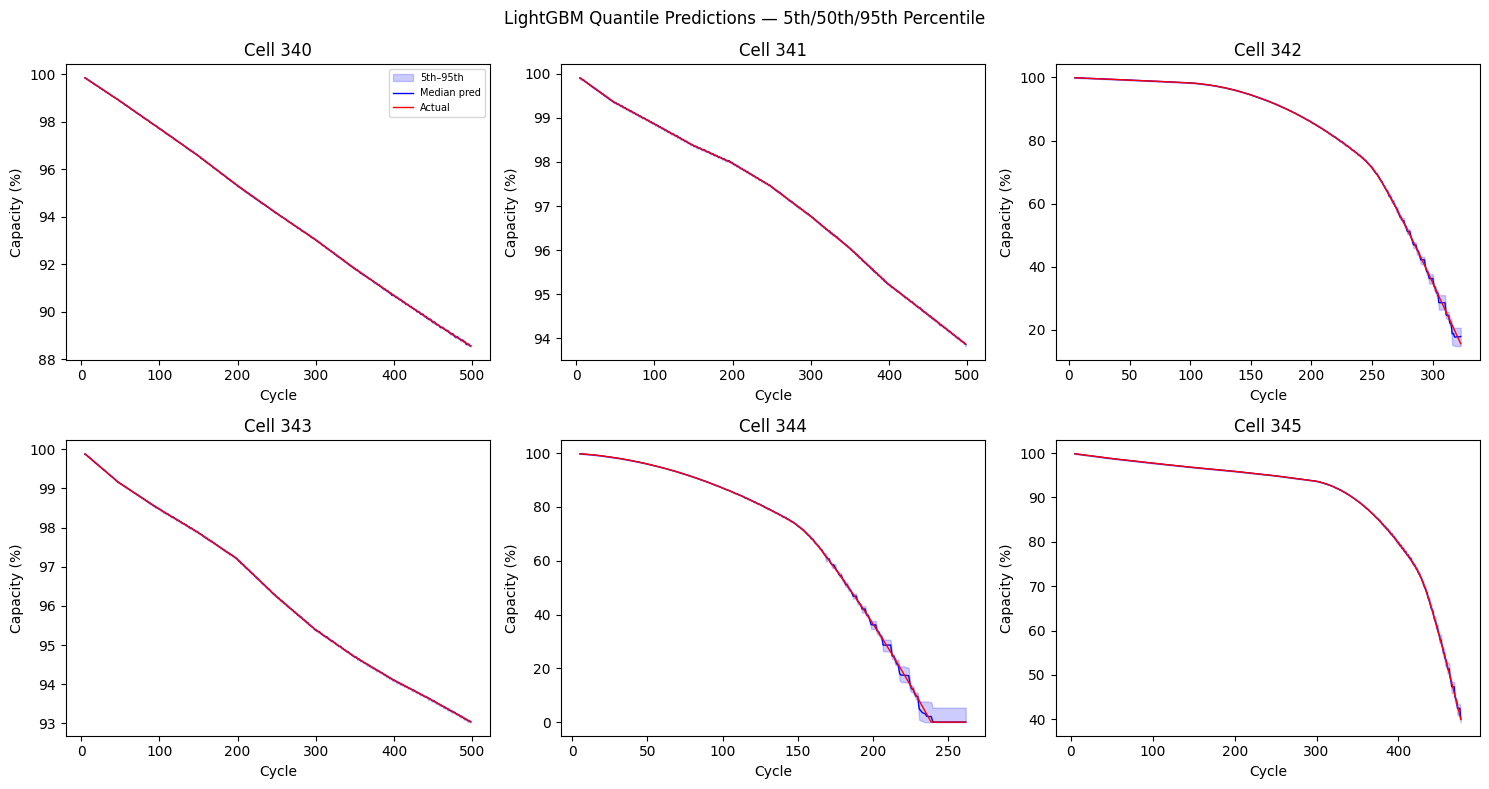

In [5]:
# Pick a few test cells and plot prediction intervals
test_cells = df[df['split'] == 'test']['cell_id'].unique()[:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, cell in enumerate(test_cells):
    cell_data = df[(df['cell_id'] == cell) & (df['split'] == 'test')].sort_values('cycle')
    X_cell = cell_data[FEATURE_COLS]
    
    low = models[0.05].predict(X_cell)
    med = models[0.50].predict(X_cell)
    high = models[0.95].predict(X_cell)
    actual = cell_data['target'].values
    cycles = cell_data['cycle'].values
    
    axes[i].fill_between(cycles, low, high, alpha=0.2, color='blue', label='5th–95th')
    axes[i].plot(cycles, med, color='blue', linewidth=1, label='Median pred')
    axes[i].plot(cycles, actual, color='red', linewidth=1, label='Actual')
    axes[i].set_title(f'Cell {cell}')
    axes[i].set_xlabel('Cycle')
    axes[i].set_ylabel('Capacity (%)')
    if i == 0:
        axes[i].legend(fontsize=7)

plt.suptitle('LightGBM Quantile Predictions — 5th/50th/95th Percentile')
plt.tight_layout()
plt.show()

## 6. SHAP Interpretability
SHAP on the 5th percentile (worst-case) model, explaining what drives the most dangerous predictions is more insightful than explaining the average case. The summary plot shows global feature importance; the dependence plot reveals how capacity history interacts with damage accumulation.

/Users/sagara/Documents/2025/Projects/Battery Failure Risk Analysis/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


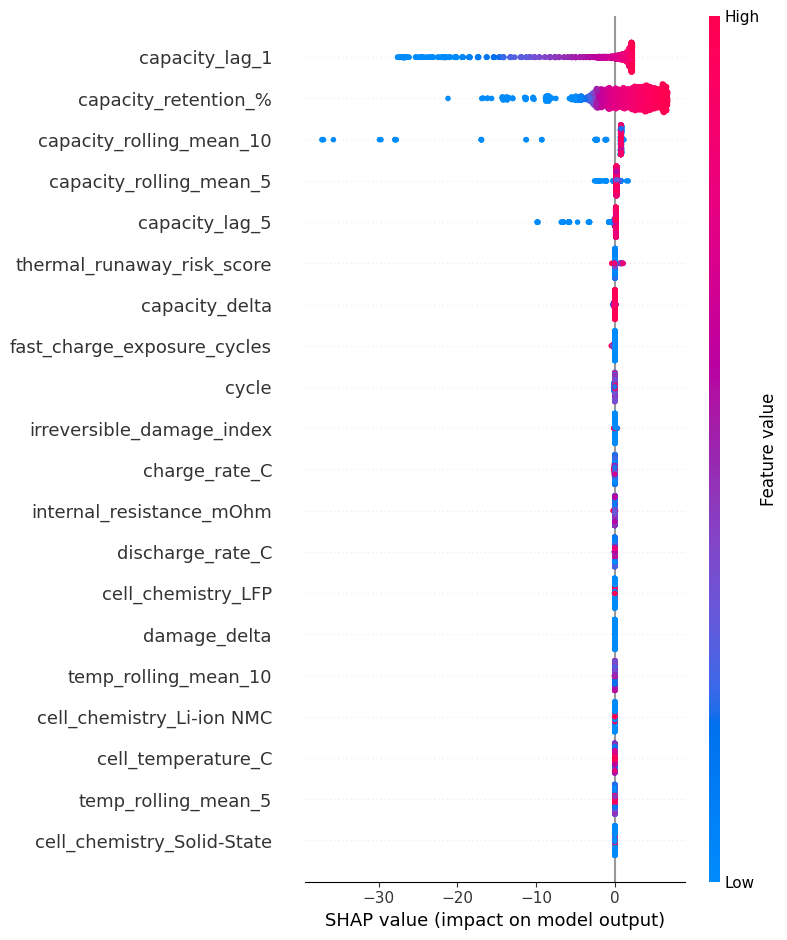

In [ ]:
import shap
# SHAP on the 5th percentile model 
explainer = shap.TreeExplainer(models[0.05])
shap_values = explainer.shap_values(X_test.sample(2000, random_state=42))

shap.summary_plot(shap_values, X_test.sample(2000, random_state=42))

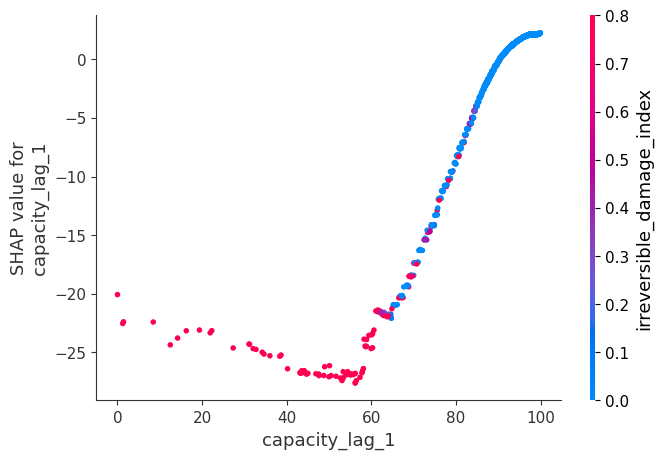

In [7]:
shap.dependence_plot('capacity_lag_1', shap_values, 
                     X_test.sample(2000, random_state=42),
                     interaction_index='irreversible_damage_index')